### Importing package

In [1]:
# Libraries
import time
import re

# Reading in files
import pandas as pd
import numpy as np
import pickle
import gzip

# Progress bar
from tqdm.auto import tqdm

# Torch modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

# Lightning modules
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc
from torchmetrics import F1Score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

# Split dataset/validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import StratifiedKFold

# For plotting
import plotly.express as px

# Importing own functions 
from importing_data import get_section_json

C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# logging purposes
import logging
logging.basicConfig(filename='./log/paper_filter_logic.log' , format='%(asctime)s | %(levelname)s: %(message)s', level=logging.NOTSET)

In [3]:
with gzip.open("data/acl-publication-info.74k.v2.full-sections.pkl", "rb") as f:
    df = pickle.load(f, encoding='bytes')

In [4]:
df = df.reset_index()

In [5]:
df["Intro_concl"] = df['json_contents'].progress_apply(get_section_json, args = [["introduction", "conclusion"]])

100%|█████████████████████████████████████████████████████████████████████████| 67732/67732 [00:01<00:00, 63657.93it/s]


In [6]:
df2 = pd.json_normalize(df['Intro_concl'])

In [7]:
df["Intro_concl_concat"] = df2['Introduction'] + df2['Conclusion'] 

In [8]:
df["Year Published"] = df["ID"].apply(lambda x: re.search("\d{4}", x).group(0))

In [9]:
df['Year Published'] = df['Year Published'].astype(int)

### Filter out paper based on ID

In [10]:
def select_appropriate_paper(paper_id, year_pub):
    
    if year_pub < 2020 and year_pub > 1989: #year publication before 2020 / Format: CYY-VPPP or CYY-VVPP / Cut off at 1990
        if paper_id[-3:] == "000":
            logging.info(f"Paper:{paper_id} - Ends with 00 or 000: Removed")
            return False
        if paper_id[0] == "W":
            logging.info(f"Paper:{paper_id} - Starts with W (Workshops): Removed")
            return False
        if paper_id[0] in ["J", "Q"]:
            logging.info(f"Paper:{paper_id} - Starts with J (CL) or Q(TACL): Added")
            return True
        
        v_pat = "(?<=\-)\d{1}" # Getting the first digit after -
        vv_pat = "(?<=\-)\d{2}" # Getting the first 2 digits after -
        
        if re.search(v_pat, paper_id):
            extracted_v = re.search(v_pat, paper_id).group(0)
        if re.search(vv_pat, paper_id):
            extracted_vv = re.search(vv_pat, paper_id).group(0)
        
        if paper_id[0] in ["P", "K", "E", "D", "N", "C", "R", "I"] and (extracted_v == "1" or extracted_vv == "01"):
            logging.info(f"Paper:{paper_id} - Starts with P K E D N C R and volume is 1 or 01: Added")
            return True 
        
        if paper_id[0] == "P" and (extracted_v == "2" or extracted_vv == "02") and year_pub <= 2018 and year_pub >= 2006:
            logging.info(f"Paper:{paper_id} - Starts with P(ACL) and volume is 2 or 02: Added")
            return True
        
        if paper_id[0] == "E" and (extracted_v == "2" or extracted_vv == "02"):
            logging.info(f"Paper:{paper_id} - Starts with E(EACL) and volume is 2 or 02: Added")
            return True
        
        if paper_id[0] == "I" and (extracted_v == "2" or extracted_vv == "02") and (year_pub in [2008, 2009, 2015, 2017]):
            logging.info(f"Paper:{paper_id} - Starts with P(ACL) and volume is 2 or 02: Added")
            return True
        
    else: #year publication 2020 and beyond / Format: {year}.{venue}-{volume}.{#}
        #Remove conference introduction papers {#}=0
        volume_pat = "(?<=\.)\d+$"
        if re.search(volume_pat, paper_id):
            extracted_volume = re.search(volume_pat, paper_id).group(0)
        
            if extracted_volume == "0":
                logging.info(f"Paper:{paper_id} - Volume 0 paper number: Removed")
                return False
        
        suffix_pat = ".*?\-(.*)\..*" #getting text between a - and .
        if re.search(suffix_pat, paper_id):
            extracted_suffix = re.search(suffix_pat, paper_id).group(1)
        
            if extracted_suffix in  ['long', 'main', 'short', '1']:
                logging.info(f"Paper:{paper_id} - Paper is a long, main, short or 1 volume: Added")
                return True
        
        prefix_pat = ".*?\.(.*)\-.*" #getting text between a . and -
        if re.search(prefix_pat, paper_id):
            extracted_prefix = re.search(prefix_pat, paper_id).group(1)

            if extracted_prefix in  ['findings', 'cl', 'tacl']:
                logging.info(f"Paper:{paper_id} - Paper is a findings, cl or tacl paper: Added")
                return True
    
    # Check for iwslt papers 
    prefix_pat = ".*?\.(.*)\-.*"
    
    if re.search(prefix_pat, paper_id):
        
        extracted_prefix = re.search(prefix_pat, paper_id).group(1)
        if extracted_prefix == "iwslt":
            suffix_pat = ".*?\-(.*)\..*" #getting text between a - and .
            if re.search(suffix_pat, paper_id):
                extracted_suffix = re.search(suffix_pat, paper_id).group(1)
        
                if extracted_suffix in  ['papers', 'evaluation', '1']:
                    logging.info(f"Paper:{paper_id} - Paper is a IWSLT paper/evaluation or 1: Added")
                    return True
    
    logging.info(f"Paper:{paper_id} - Does not fit into any logic: Removed")
    
    return False

In [11]:
df["Filter"] = df.progress_apply(lambda x: select_appropriate_paper(x['acl_id'], x['Year Published']), axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 67732/67732 [00:03<00:00, 19769.99it/s]


In [12]:
df = df[df['Filter']]

### Importing classification model

In [13]:
train_df = pd.read_csv("./Data/Collated_dataset_for_scientific_papers.csv")

In [14]:
train_df = train_df[["Intro Concl", "Labels"]]

In [15]:
train_df.columns = ["string", "label"]

In [16]:
possible_labels = list(train_df['label'].unique())
possible_labels_num = list(range(0,len(possible_labels)))

In [17]:
MODEL_NAME = 'allenai/specter'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [18]:
mapping = zip(possible_labels, possible_labels_num)
label_to_idx = {label: num  for label, num in mapping}
mapping = zip(possible_labels, possible_labels_num)
idx_to_label = {num: label for label, num in mapping}

In [19]:
MAX_TOKEN_COUNT = 512
N_EPOCHS = 5
BATCH_SIZE = 8 # Changes: Edit the batch size here
KFOLD = 5

In [20]:
class SpecterDataset(Dataset):
    
    def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, max_token_len: int = MAX_TOKEN_COUNT, mapping = label_to_idx):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
        self.mapping = mapping
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
    
        data_row = self.data.iloc[index]
        text = data_row["string"]
        labels = self.mapping[data_row["label"]]

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_token_len,
          return_token_type_ids=False,
          padding="max_length",
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return dict(
          text=text,
          input_ids=encoding["input_ids"].flatten(),
          attention_mask=encoding["attention_mask"].flatten(),
          labels=labels
        )

In [21]:
class SpecterDataModule(pl.LightningDataModule):
    
    def __init__(self, df,
                 tokenizer,
                 k = 0,  # fold number
                 split_seed = 123,  # split needs to be always the same for correct cross validation
                 num_splits = KFOLD,
                 batch_size = BATCH_SIZE, 
                 max_token_len = MAX_TOKEN_COUNT,
                 num_workers = 0,
                 pin_memory = False):
        
        super().__init__()

        self.save_hyperparameters(logger=False)
    
    def setup(self, stage=None):

        # choose fold to train on
        kf = StratifiedKFold(n_splits=self.hparams.num_splits, shuffle=True, random_state=self.hparams.split_seed)
        all_splits = [k for k in kf.split(df, df.label)]
        train_indexes, val_indexes = all_splits[self.hparams.k]
        train_indexes, val_indexes = train_indexes.tolist(), val_indexes.tolist()

        self.data_train, self.data_val = df.iloc[train_indexes], df.iloc[val_indexes]
        
        self.train_dataset = SpecterDataset(
          self.data_train,
          self.hparams.tokenizer,
          self.hparams.max_token_len
        )
        self.val_dataset = SpecterDataset(
          self.data_val,
          self.hparams.tokenizer,
          self.hparams.max_token_len
        )
        
    def train_dataloader(self):
        return DataLoader(
          self.train_dataset,
          batch_size = self.hparams.batch_size,
          shuffle=True
        )
    
    def val_dataloader(self):
        return DataLoader(
          self.val_dataset,
          batch_size = self.hparams.batch_size
        )

### Modelling

In [22]:
class SpecterClassModel(pl.LightningModule):
    
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
        super().__init__()
        self.specter = AutoModel.from_pretrained(MODEL_NAME, return_dict=True)
        # Changes: Edit model architecture forward pass here
        self.classifier = nn.Linear(self.specter.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.CrossEntropyLoss()
        self.acc = MulticlassAccuracy(num_classes = 21, average = 'weighted') #measure performance based on weighted average
        self.f1 = MulticlassF1Score(num_classes = 21, average = 'weighted')
        self.prec = MulticlassPrecision(num_classes = 21, average = 'weighted')
        self.rec = MulticlassRecall(num_classes = 21, average = 'weighted')
        
        # Changes: Comment below code to remove freezing of the SPECTER embeddings
        for name, param in self.specter.named_parameters():
            if name.startswith('embeddings'):
                param.requires_grad = False
    
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.specter(input_ids, attention_mask=attention_mask)
        # Changes: Edit model architecture forward pass here
        output = self.classifier(output.pooler_output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
            # acc = self.acc(output, labels)
            # f1 = self.f1(output, labels)
            # prec = self.prec(output, labels)
            # rec = self.rec(output, labels)
        return loss, output #, acc, f1, prec, rec

    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        #loss, output, acc, f1, prec, rec = self(input_ids, attention_mask, labels)
        loss, output = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": output, "labels": labels}

    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        #loss, output, acc, f1, prec, rec = self(input_ids, attention_mask, labels)
        loss, output = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": output, "labels": labels}
    
    def training_epoch_end(self, outputs):
        avg_loss = sum(output['loss'].item() for output in outputs) / len(outputs)
        
        predictions = torch.cat([output['predictions'] for output in outputs])
        labels = torch.cat([output['labels'] for output in outputs])
        
        acc = self.acc(predictions, labels)
        f1 = self.f1(predictions, labels)
        prec = self.prec(predictions, labels)
        rec = self.rec(predictions, labels)
        print(f"******Train epoch {self.current_epoch} eval metrics: loss {avg_loss:.8f}, f1 {f1:.4f} prec {prec:.4f} rec {rec:.4f}, acc {acc:.4f}")
        
        self.logger.experiment.add_scalars('loss', {'train': avg_loss}, self.current_epoch)    
    
    def validation_epoch_end(self, outputs):
        avg_loss = sum(output['loss'].item() for output in outputs) / len(outputs)

        predictions = torch.cat([output['predictions'] for output in outputs])
        labels = torch.cat([output['labels'] for output in outputs])
        
        acc = self.acc(predictions, labels)
        f1 = self.f1(predictions, labels)
        prec = self.prec(predictions, labels)
        rec = self.rec(predictions, labels)
        print(f"******Val epoch {self.current_epoch} eval metrics: loss {avg_loss:.8f}, f1 {f1:.4f} prec {prec:.4f} rec {rec:.4f}, acc {acc:.4f}")
        
        #For final output
        self.log("Ignore/acc", acc, logger=True)
        self.log("Ignore/f1", f1, logger=True)
        self.log("Ignore/prec", prec, logger=True)
        self.log("Ignore/rec", rec, logger=True)
        
        #For Tensorboard visualisaion with Epoch as x axis
        self.logger.experiment.add_scalar('Collated/acc', acc, self.current_epoch)
        self.logger.experiment.add_scalar('Collated/f1', f1, self.current_epoch)
        self.logger.experiment.add_scalar('Collated/prec', prec, self.current_epoch)
        self.logger.experiment.add_scalar('Collated/rec', rec, self.current_epoch)
    
        self.logger.experiment.add_scalars('loss', {'val': avg_loss}, self.current_epoch)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5) # Changes: Edit the learning rate
        scheduler = get_linear_schedule_with_warmup( # Changes: Edit the scheduler
          optimizer,
          num_warmup_steps=self.n_warmup_steps,
          num_training_steps=self.n_training_steps
        )
        
        # Changes: Edit the optimizer
        return dict(
          optimizer = optimizer,
          lr_scheduler = dict(
            scheduler = scheduler,
            interval = 'step'
          )
        )

In [23]:
trained_model = SpecterClassModel.load_from_checkpoint(
  './Experiments/checkpoints/best-checkpoint-Default.ckpt',
  n_classes = 21
)

trained_model.eval()
trained_model.freeze()

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

In [25]:
df_for_pred = df[['Intro_concl_concat']]

In [26]:
df_for_pred['label'] = "Summarization"

C:\Users\Benjamin Aw\AppData\Local\Temp\ipykernel_8552\2342050073.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_pred['label'] = "Summarization"


In [27]:
df_for_pred.columns = ("string", "label")

In [28]:
pred_dataset = SpecterDataset(
    df_for_pred,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(pred_dataset):
    
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    
    predictions.append(prediction.flatten())
    labels.append(item["labels"])

predictions = torch.stack(predictions).detach().cpu()
labels = torch.IntTensor(labels).detach().cpu()

100%|████████████████████████████████████████████████████████████████████████████| 31717/31717 [08:40<00:00, 60.90it/s]


In [29]:
labelled_prediction = [idx_to_label[pred] for pred in torch.argmax(predictions, dim=1).tolist()]

In [30]:
df["Model Predicted Topics"] = labelled_prediction

In [ ]:
df = df[df['Intro_concl_concat'] != ""]

In [135]:
df.to_parquet("./Data/Inference for Hot topic classification.parquet", index = False)

### Finding out emerging topics

In [136]:
# Start from here
df = pd.read_parquet("./Data/Inference for Hot topic classification.parquet")

In [137]:
emerge_df = df[["Year Published", "Model Predicted Topics"]]

In [138]:
emerge_df

Year Published                             Model Predicted Topics
0                2013                           Resources and Evaluation
1                2013  Semantics: Sentence-level Semantics, Textual I...
2                2013        Phonology, Morphology and Word Segmentation
3                2013                       Semantics: Lexical Semantics
4                2013                   Dialogue and Interactive Systems
...               ...                                                ...
29603            1999                           Speech and Multimodality
29604            2000              Syntax: Tagging, Chunking and Parsing
29605            1999  Linguistic Theories, Cognitive Modeling and Ps...
29606            1999                       Semantics: Lexical Semantics
29607            2000                   Dialogue and Interactive Systems

[29608 rows x 2 columns]

In [139]:
year_topic_count = emerge_df.groupby(['Year Published', 'Model Predicted Topics']).size()

In [140]:
year_topic_count = year_topic_count.reset_index(name='Topic Count')

In [141]:
year_topic_count = year_topic_count[year_topic_count['Year Published'] >= 1990]

In [142]:
color_discrete_map={"Dialogue and Interactive Systems": "#db7093",
                    "Discourse and Pragmatics": "#7f0000",
                    "Generation": "#808000",
                    "Language Grounding to Vision, Robotics and Beyond": "#483d8b",
                    "Linguistic Theories, Cognitive Modeling and Psycholinguistics": "#008000",
                    "Machine Translation and Multilinguality": "#008b8b",
                    "Phonology, Morphology and Word Segmentation": "#00008b",
                    "Resources and Evaluation": "#b03060",
                    "Semantics: Lexical Semantics": "#ff4500",
                    "Semantics: Sentence-level Semantics, Textual Inference and Other areas": "#ffa500",
                    "Speech and Multimodality": "#ffff00",
                    "Syntax: Tagging, Chunking and Parsing": "#00ff00",
                    "Information Retrieval and Text Mining": "#ba55d3",
                    "Interpretability and Analysis of Models for NLP": "#00fa9a",
                    "Machine Learning for NLP": "#e9967a",
                    "Computational Social Science and Social Media": "#00ffff",
                    "Information Extraction": "#00bfff",
                    "Summarization": "#0000ff",
                    "Question Answering": "#ff00ff",
                    "Sentiment Analysis, Stylistic Analysis, and Argument Mining": "#f0e68c",
                    "Ethics and NLP": "#dda0dd"}

In [143]:
color_discrete_map = dict(zip(list(year_topic_count['Model Predicted Topics'].unique()), (px.colors.qualitative.Plotly * 3)[0:21]))

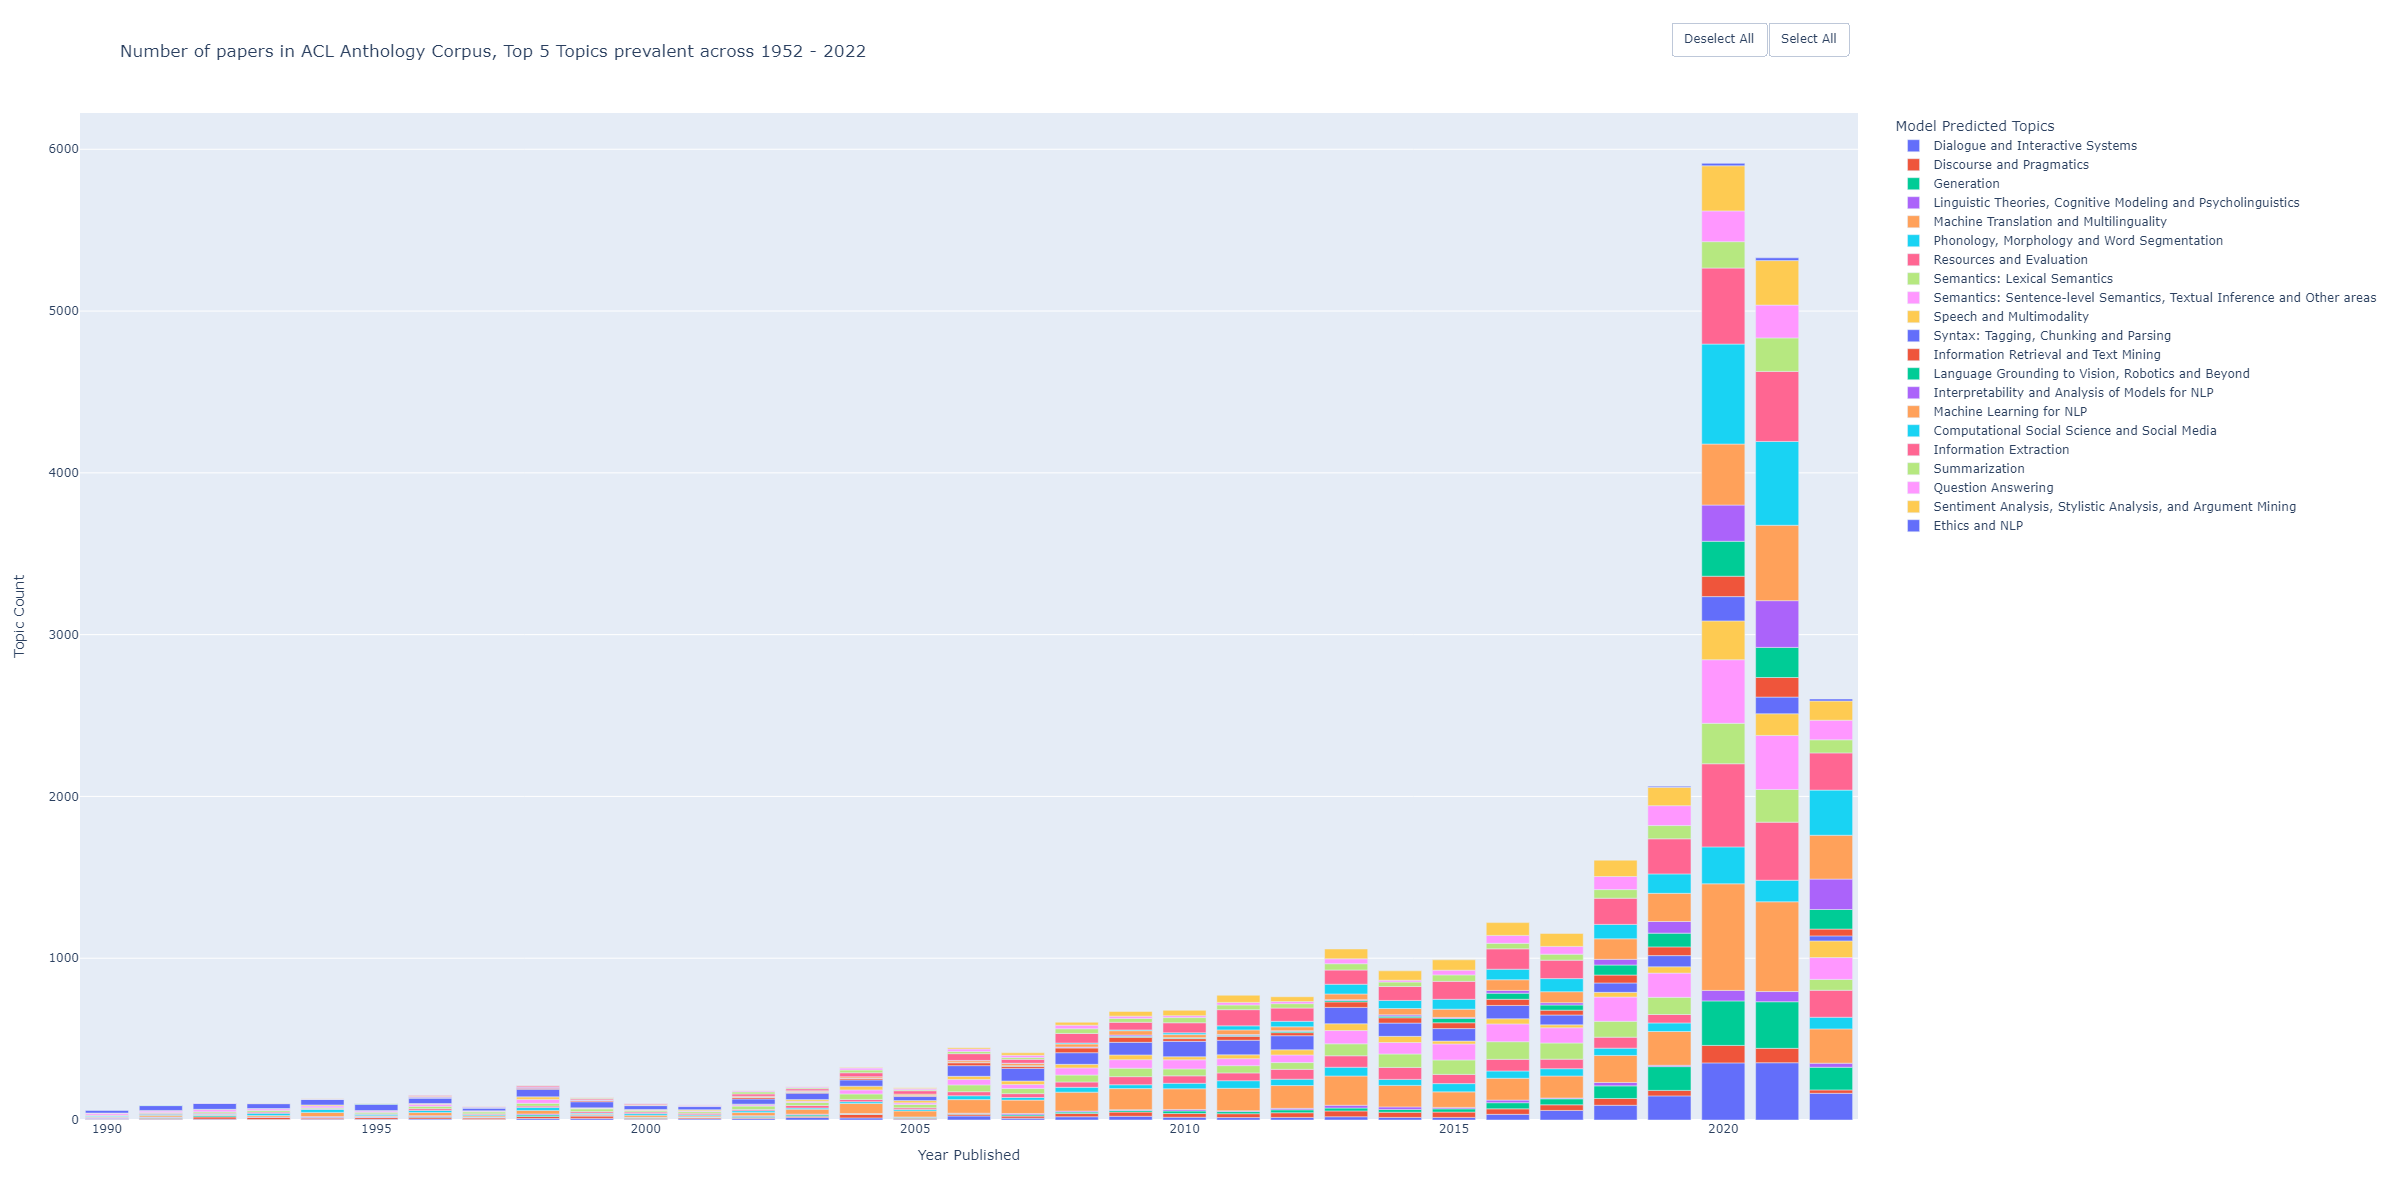

In [144]:
fig = px.bar(year_topic_count, x="Year Published", y="Topic Count", color="Model Predicted Topics", color_discrete_map = color_discrete_map, title="Number of papers in ACL Anthology Corpus, Top 5 Topics prevalent across 1952 - 2022",
             width=1800, height=1200)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))

fig.show()

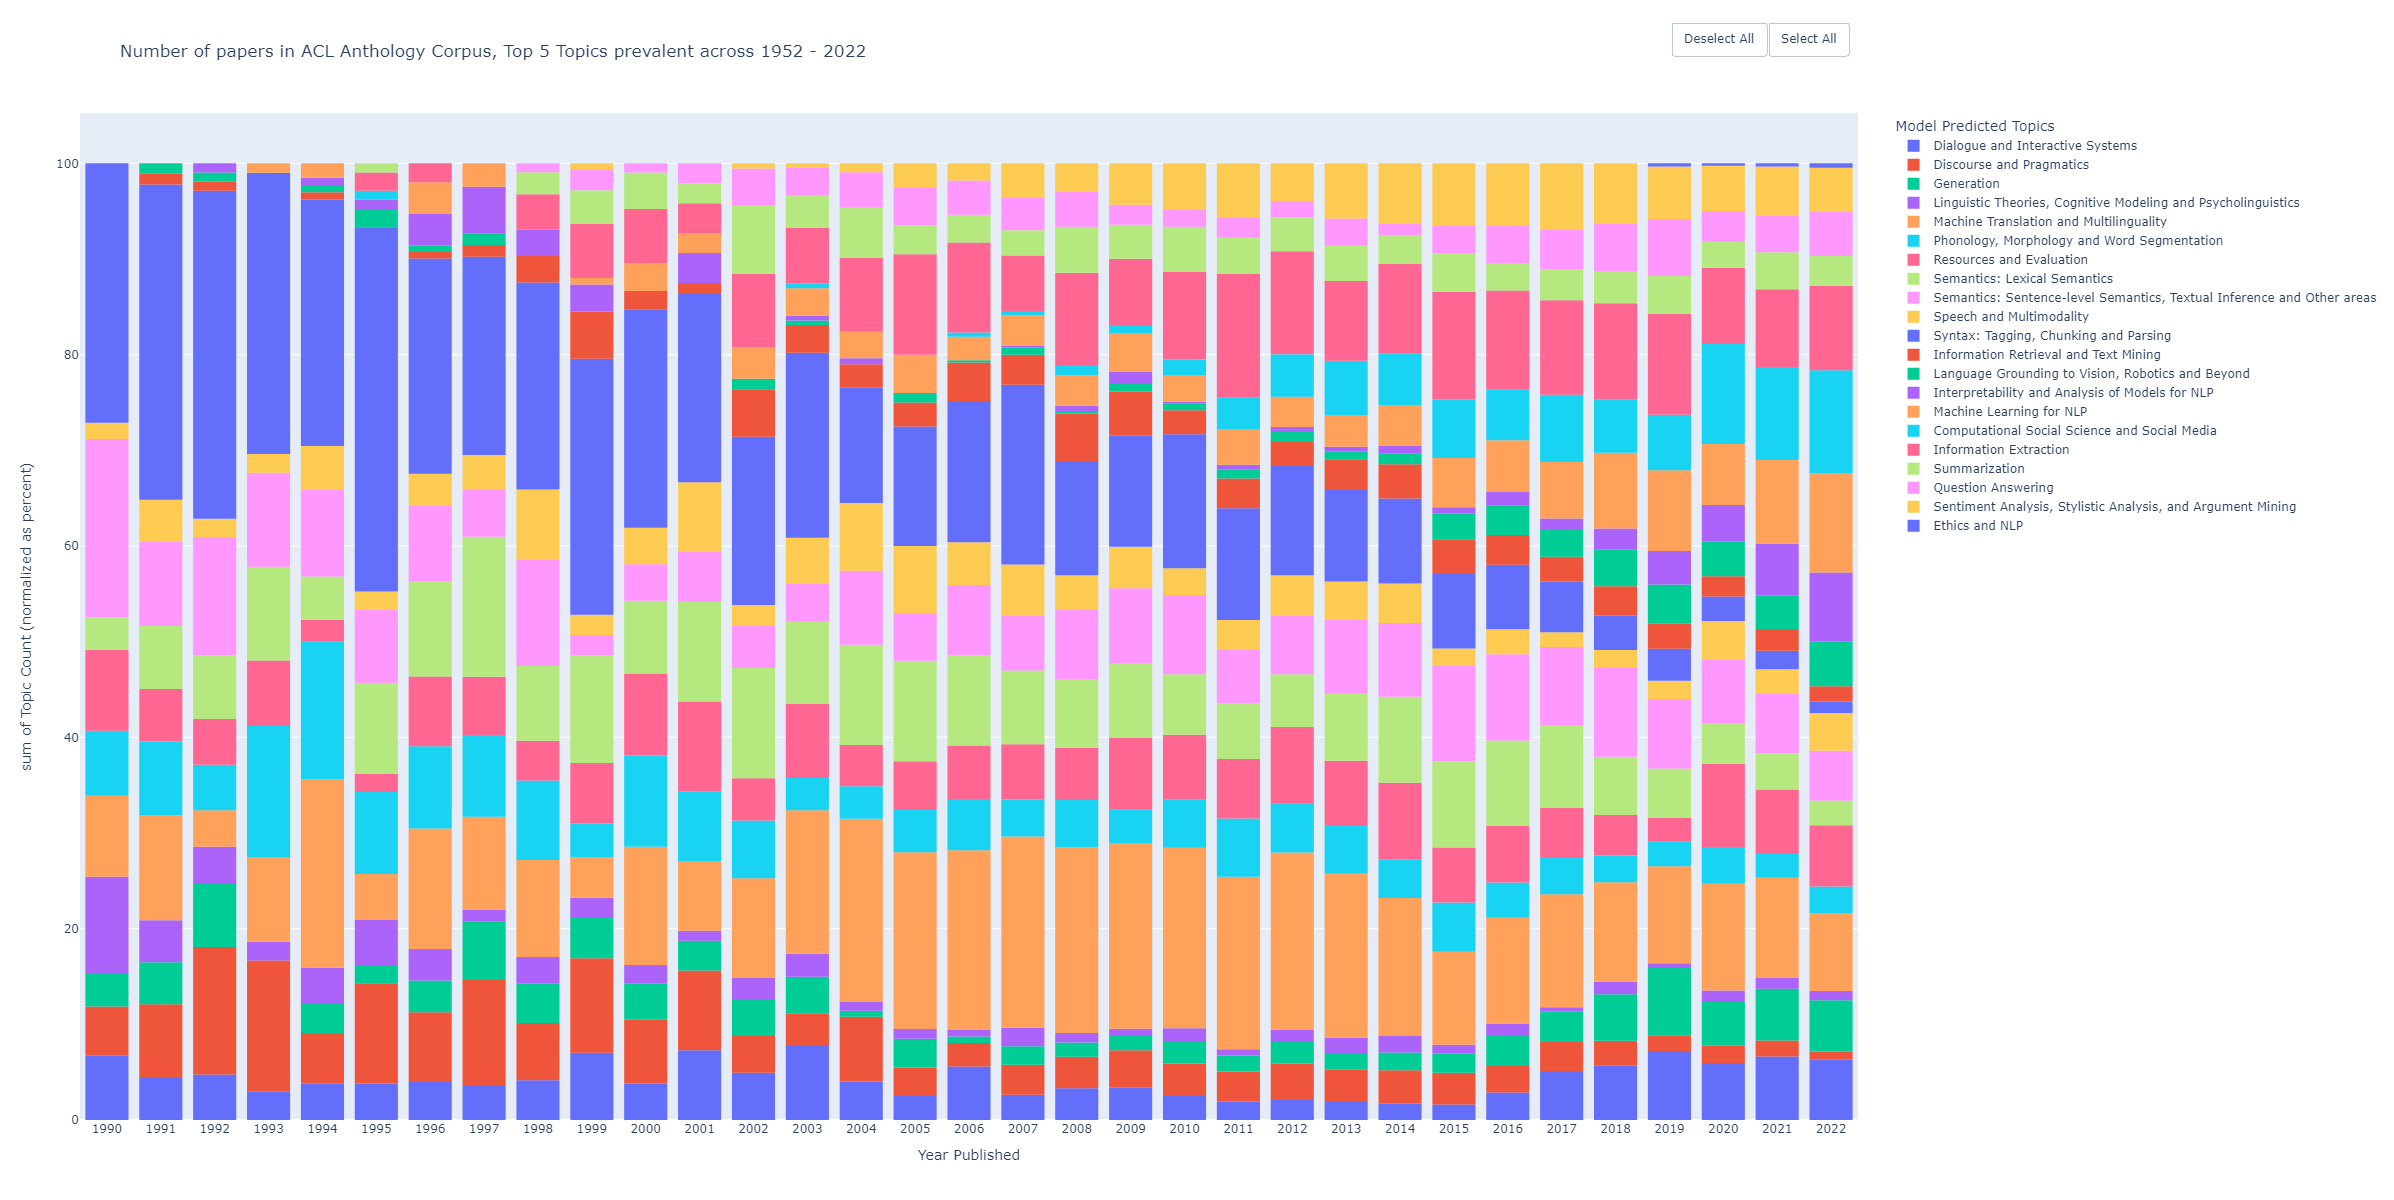

In [145]:
# To look at the percentage change instead of just flat number
year_topic_count_filt = year_topic_count.copy()
year_topic_count_filt['Year Published'] = year_topic_count_filt['Year Published'].astype('str')

fig = px.histogram(year_topic_count_filt, x="Year Published", y="Topic Count", color="Model Predicted Topics", barnorm='percent', color_discrete_map = color_discrete_map, title="Number of papers in ACL Anthology Corpus, Top 5 Topics prevalent across 1952 - 2022",
             width=1800, height=1200)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))

fig.show()

### Chosing the top 5 topics to display

In [146]:
year_topic_count.groupby(['Model Predicted Topics']).size().reset_index(name='Topic Appearance ac years').sort_values(by = "Topic Appearance ac years", ascending = False)

Model Predicted Topics  \
20              Syntax: Tagging, Chunking and Parsing   
12        Phonology, Morphology and Word Segmentation   
2                            Discourse and Pragmatics   
18                           Speech and Multimodality   
16  Semantics: Sentence-level Semantics, Textual I...   
15                       Semantics: Lexical Semantics   
14                           Resources and Evaluation   
9   Linguistic Theories, Cognitive Modeling and Ps...   
1                    Dialogue and Interactive Systems   
11            Machine Translation and Multilinguality   
4                                          Generation   
6               Information Retrieval and Text Mining   
10                           Machine Learning for NLP   
5                              Information Extraction   
8   Language Grounding to Vision, Robotics and Beyond   
7     Interpretability and Analysis of Models for NLP   
19                                      Summarization   
13                                 Question Answering   
17  Sentiment Analysis, Stylistic Analysis, and Ar...   
0       Computational Social Science and Social Media   
3                                      Ethics and NLP   

    Topic Appearance ac years  
20                         33  
12                         33  
2                          33  
18                         33  
16                         33  
15                         33  
14                         33  
9                          33  
1                          33  
11                         33  
4                          32  
6                          30  
10                         28  
5                          27  
8                          26  
7                          26  
19                         26  
13                         25  
17                         22  
0                          19  
3                           4

In [147]:
top_5_topics = list(year_topic_count.groupby(['Model Predicted Topics']).size().reset_index(name='Topic Appearance ac years').sort_values(by = "Topic Appearance ac years", ascending = False)['Model Predicted Topics'][0:5])

C:\Users\Benjamin Aw\AppData\Local\Temp\ipykernel_8552\1788818505.py:1: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [148]:
df_plot_1 = year_topic_count[year_topic_count['Model Predicted Topics'].isin(top_5_topics)]

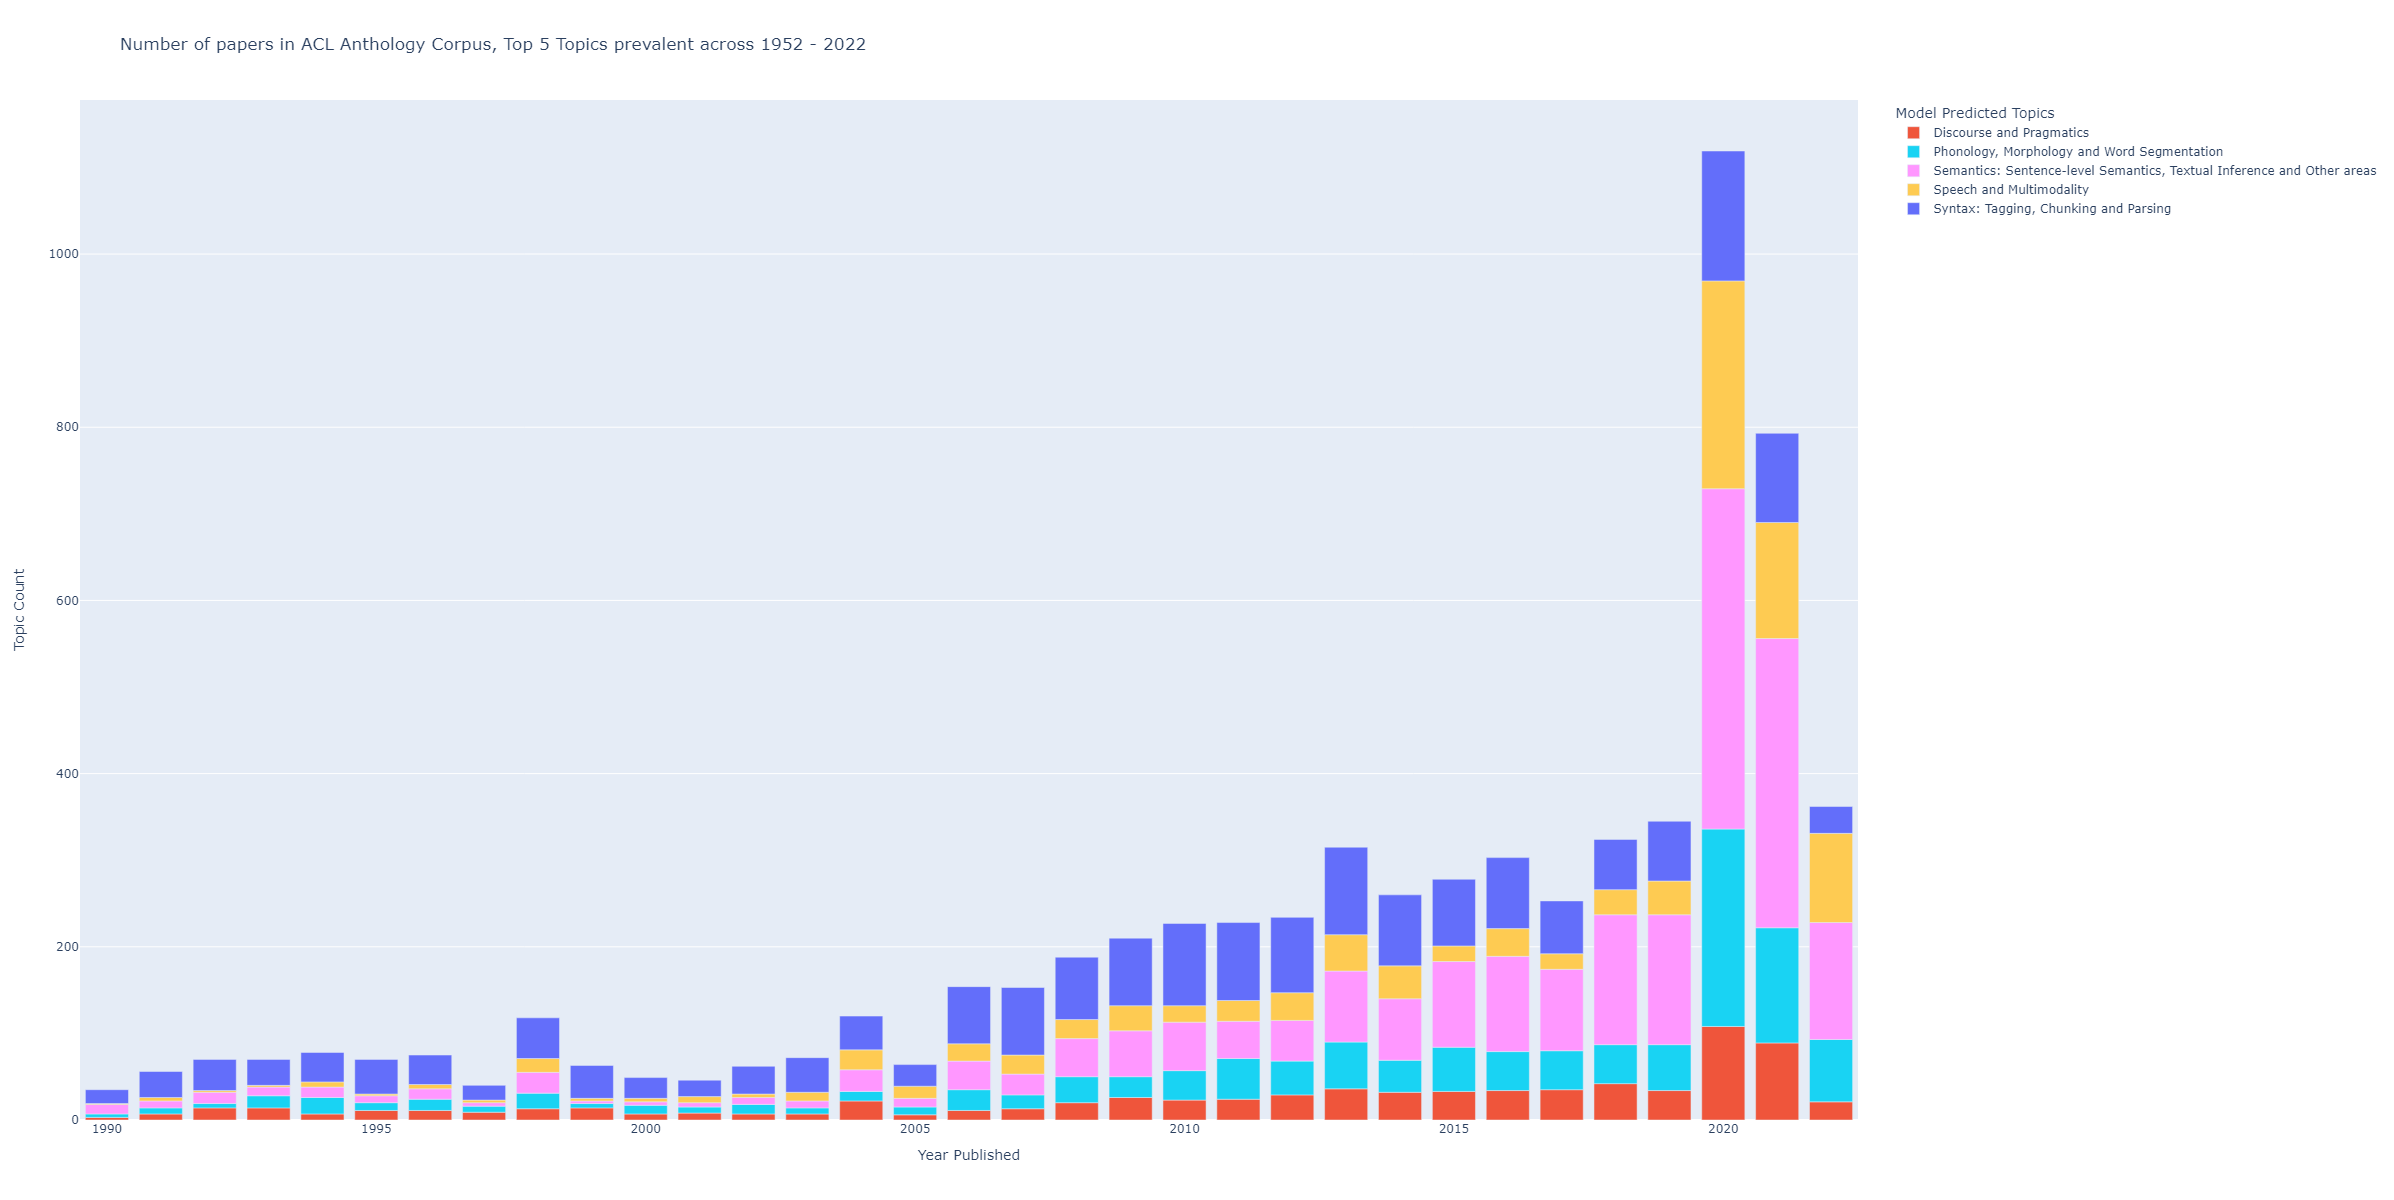

In [149]:
import plotly.express as px

fig = px.bar(df_plot_1, x="Year Published", y="Topic Count", color_discrete_map = color_discrete_map, color="Model Predicted Topics", title="Number of papers in ACL Anthology Corpus, Top 5 Topics prevalent across 1952 - 2022",
             width=1800, height=1200)
fig.show()

### Calculating burstiness of a topic

In [150]:
emerge_df

Year Published                             Model Predicted Topics
0                2013                           Resources and Evaluation
1                2013  Semantics: Sentence-level Semantics, Textual I...
2                2013        Phonology, Morphology and Word Segmentation
3                2013                       Semantics: Lexical Semantics
4                2013                   Dialogue and Interactive Systems
...               ...                                                ...
29603            1999                           Speech and Multimodality
29604            2000              Syntax: Tagging, Chunking and Parsing
29605            1999  Linguistic Theories, Cognitive Modeling and Ps...
29606            1999                       Semantics: Lexical Semantics
29607            2000                   Dialogue and Interactive Systems

[29608 rows x 2 columns]

In [151]:
def generating_Zct(emerge_df, k, start_date, end_date):
    
    f_c_t = emerge_df.groupby(['Year Published', 'Model Predicted Topics']).size().unstack(fill_value=0).stack()
    f_c_t = f_c_t.reset_index(name='Topic Count')
    f_c_t = f_c_t.sort_values(['Model Predicted Topics', 'Year Published'])
    
    f_c_t['Year Published'] = f_c_t['Year Published'].astype(int)
    
    # Counting the number of papers published per year
    N_t = f_c_t.groupby('Year Published')['Topic Count'].sum()
    N_t = N_t.reset_index(name='Paper Count')
    
    pc = f_c_t.groupby('Model Predicted Topics')['Topic Count'].rolling(k*2+1, min_periods = 1, center = True).sum().reset_index(name='Sliding sum of topic count')
    year_idx_mapping = f_c_t['Year Published'].reset_index(name='Year Published')
    
    pc = pc.merge(year_idx_mapping, left_on = 'level_1', right_on = 'index', how = 'inner').drop(['level_1', 'index'], axis = 1)
    pc = pc[["Year Published", "Model Predicted Topics", "Sliding sum of topic count"]]
    
    N_t['Sliding sum of total paper count'] = N_t['Paper Count'].rolling(k*2+1, min_periods = 1, center = True).sum()
    
    pc = pc.merge(N_t, on = 'Year Published', how = 'left')
    pc['Pc'] = pc['Sliding sum of topic count'] / pc['Sliding sum of total paper count']
    
    #This gives me N_t [Paper Count](total number of papers published per year), f_c_t [Topic Count](paper of a particular topic published per year) and p_c [Pc](expected probability count for topic per year)
    f_c_t = f_c_t.merge(pc, on = ['Year Published', 'Model Predicted Topics'], how = 'left')
    
    z_c_t = f_c_t.copy()
    z_c_t["Expected value"] = z_c_t['Paper Count'] * z_c_t['Pc']
    z_c_t["SD value"] = (z_c_t['Paper Count'] * z_c_t['Pc'] * (1 - z_c_t['Pc']))**(1/2)
    
    z_c_t['Zct'] = (z_c_t['Topic Count'] - z_c_t['Expected value'])/z_c_t['SD value']
    
    z_c_t['Zct'] = z_c_t['Zct'].fillna(0)
    z_c_t = z_c_t.sort_values(by="Year Published")
    z_c_t = z_c_t[(z_c_t['Year Published'] >= start_date) & (z_c_t['Year Published'] <= end_date)]
    
    return z_c_t

In [152]:
z_c_t = generating_Zct(emerge_df, 1, 2000, 2021) # Rolling window of t-k to t+k

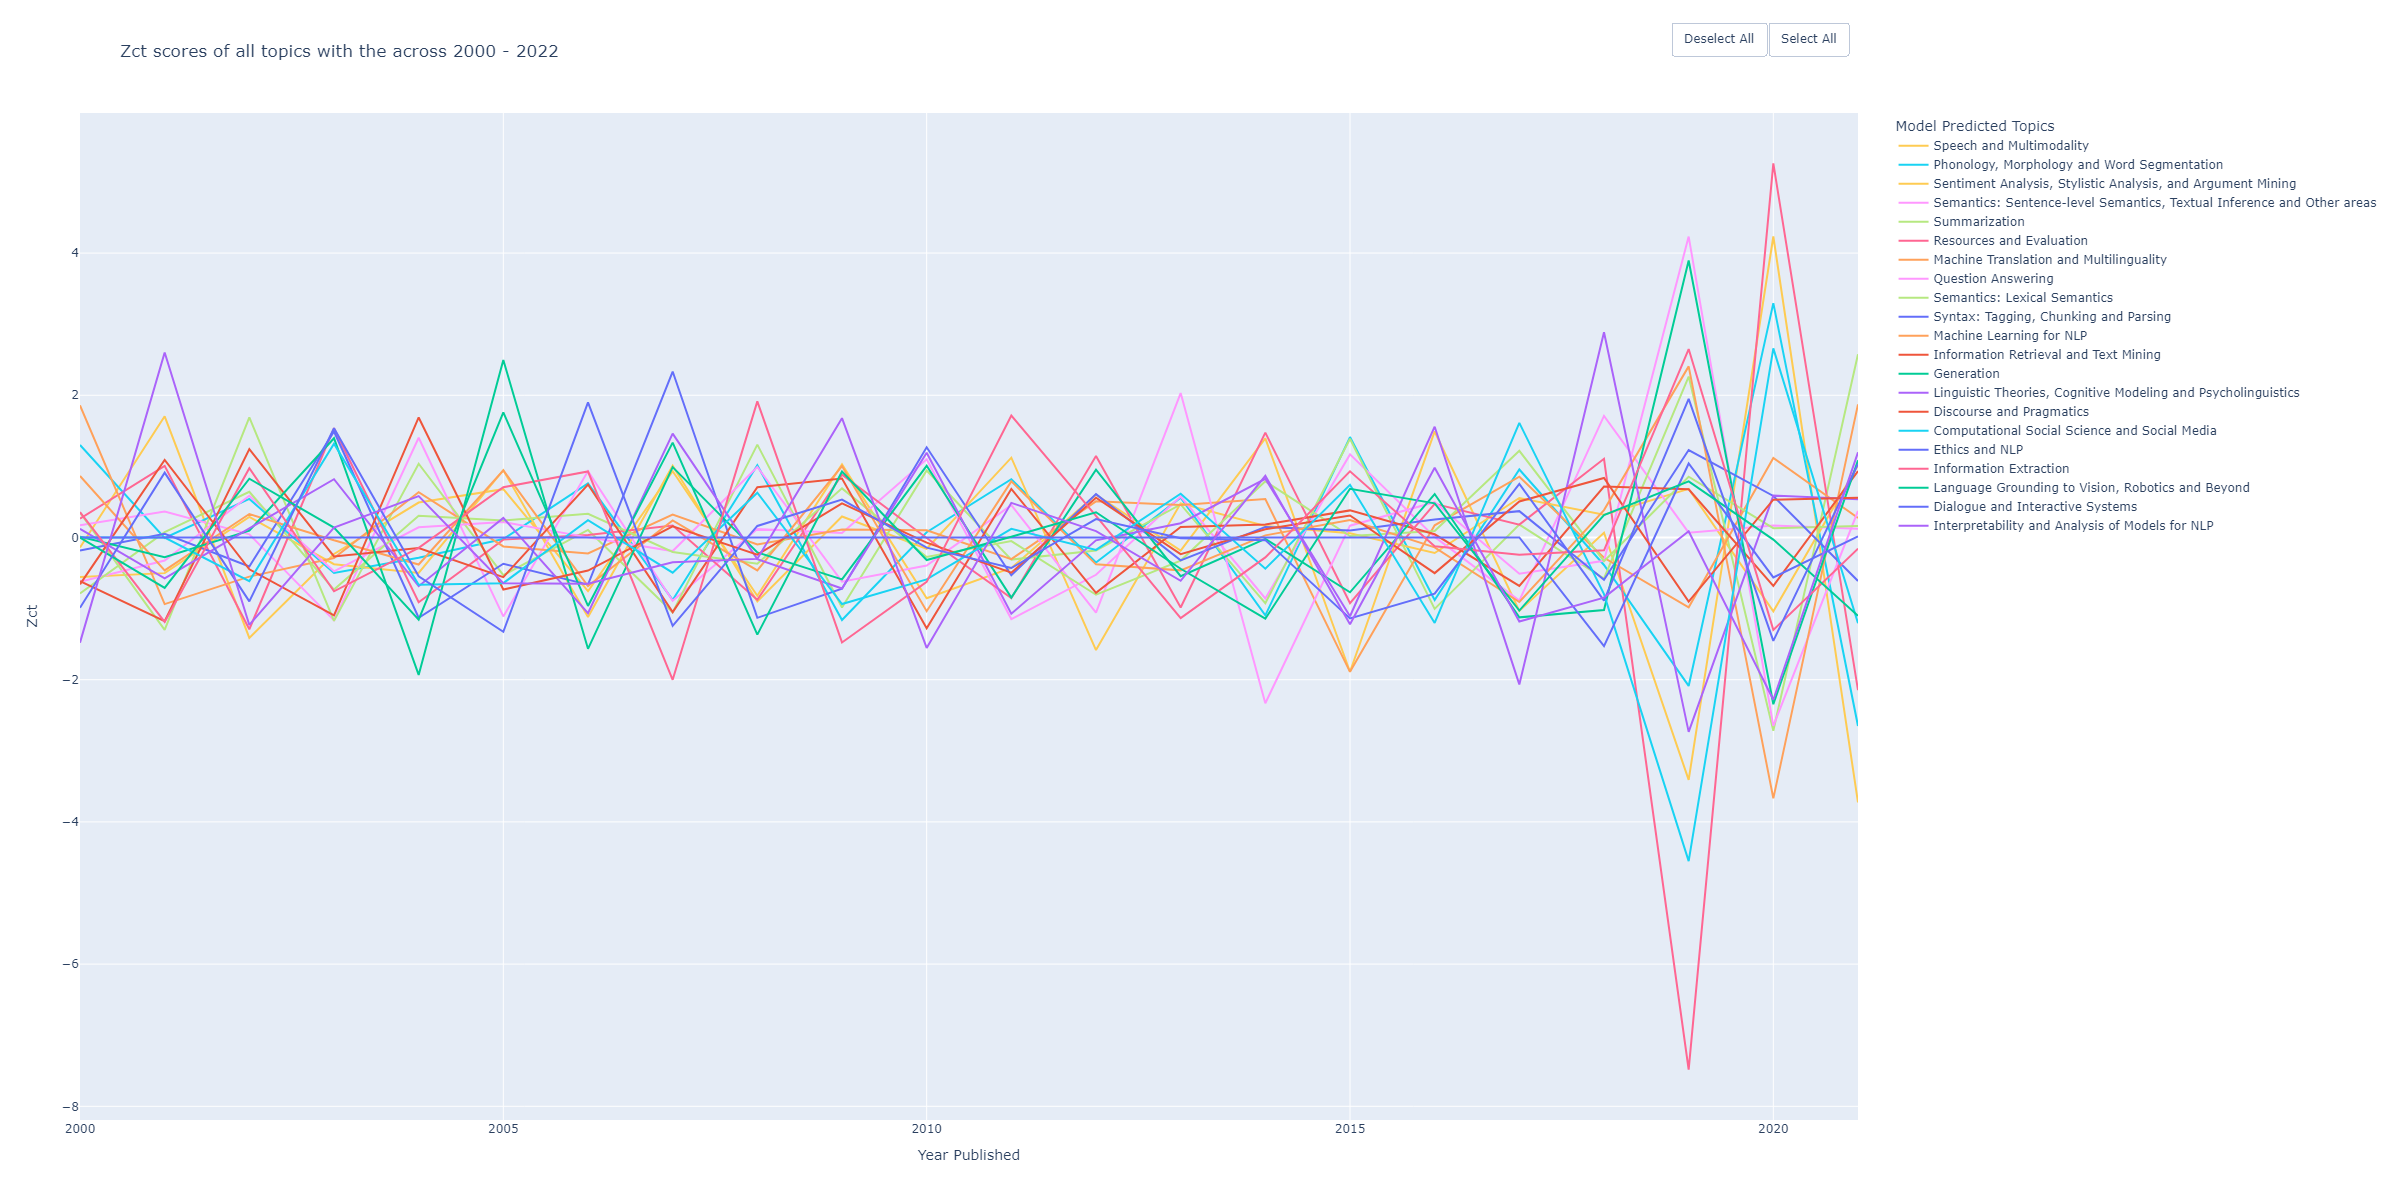

In [153]:
fig = px.line(z_c_t, x="Year Published", y="Zct", color="Model Predicted Topics", color_discrete_map = color_discrete_map, title="Zct scores of all topics with the across 2000 - 2022",
             width=1800, height=1200)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))

fig.show()

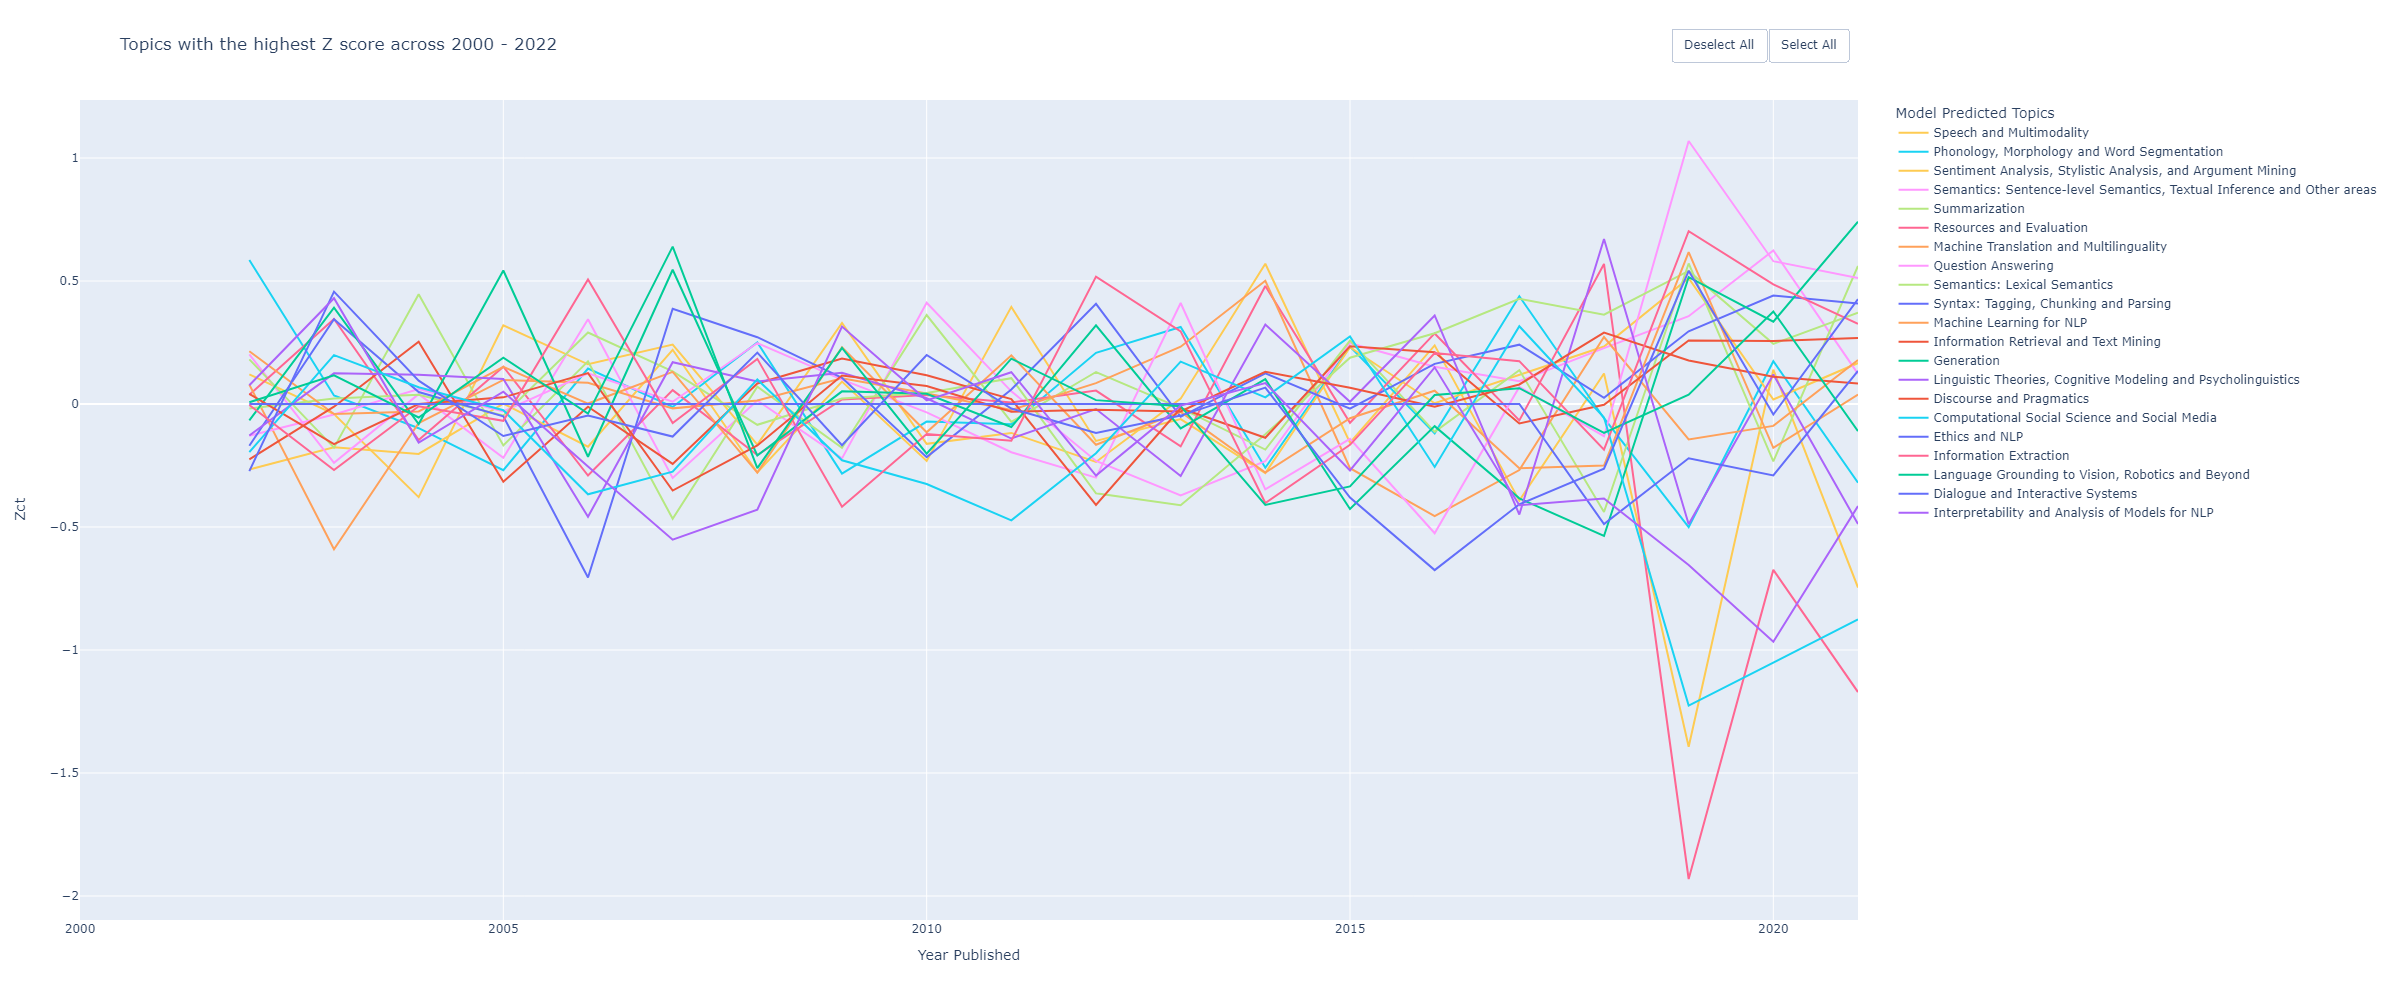

In [154]:
fig = px.scatter(z_c_t, x="Year Published", y="Zct", color="Model Predicted Topics", color_discrete_map = color_discrete_map, title="Topics with the highest Z score across 2000 - 2022",
                 trendline="rolling", 
                 trendline_options=dict(window=3, win_type="gaussian", function_args=dict(std=2)),
                 width=2300,
                 height=1000)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))
fig.data = [t for t in fig.data if t.mode == "lines"]
fig.update_traces(showlegend=True)
fig.show()

### Plot top 5 topics with the widest z score with trendlines (gaussian rolling mean)

In [155]:
Topics_of_interest = list(z_c_t.groupby('Model Predicted Topics')['Zct'].agg(np.ptp).reset_index(name = "Diff z score").nlargest(5, "Diff z score")['Model Predicted Topics'])

In [156]:
pldf_plot_3 = z_c_t[z_c_t['Model Predicted Topics'].isin(Topics_of_interest)]

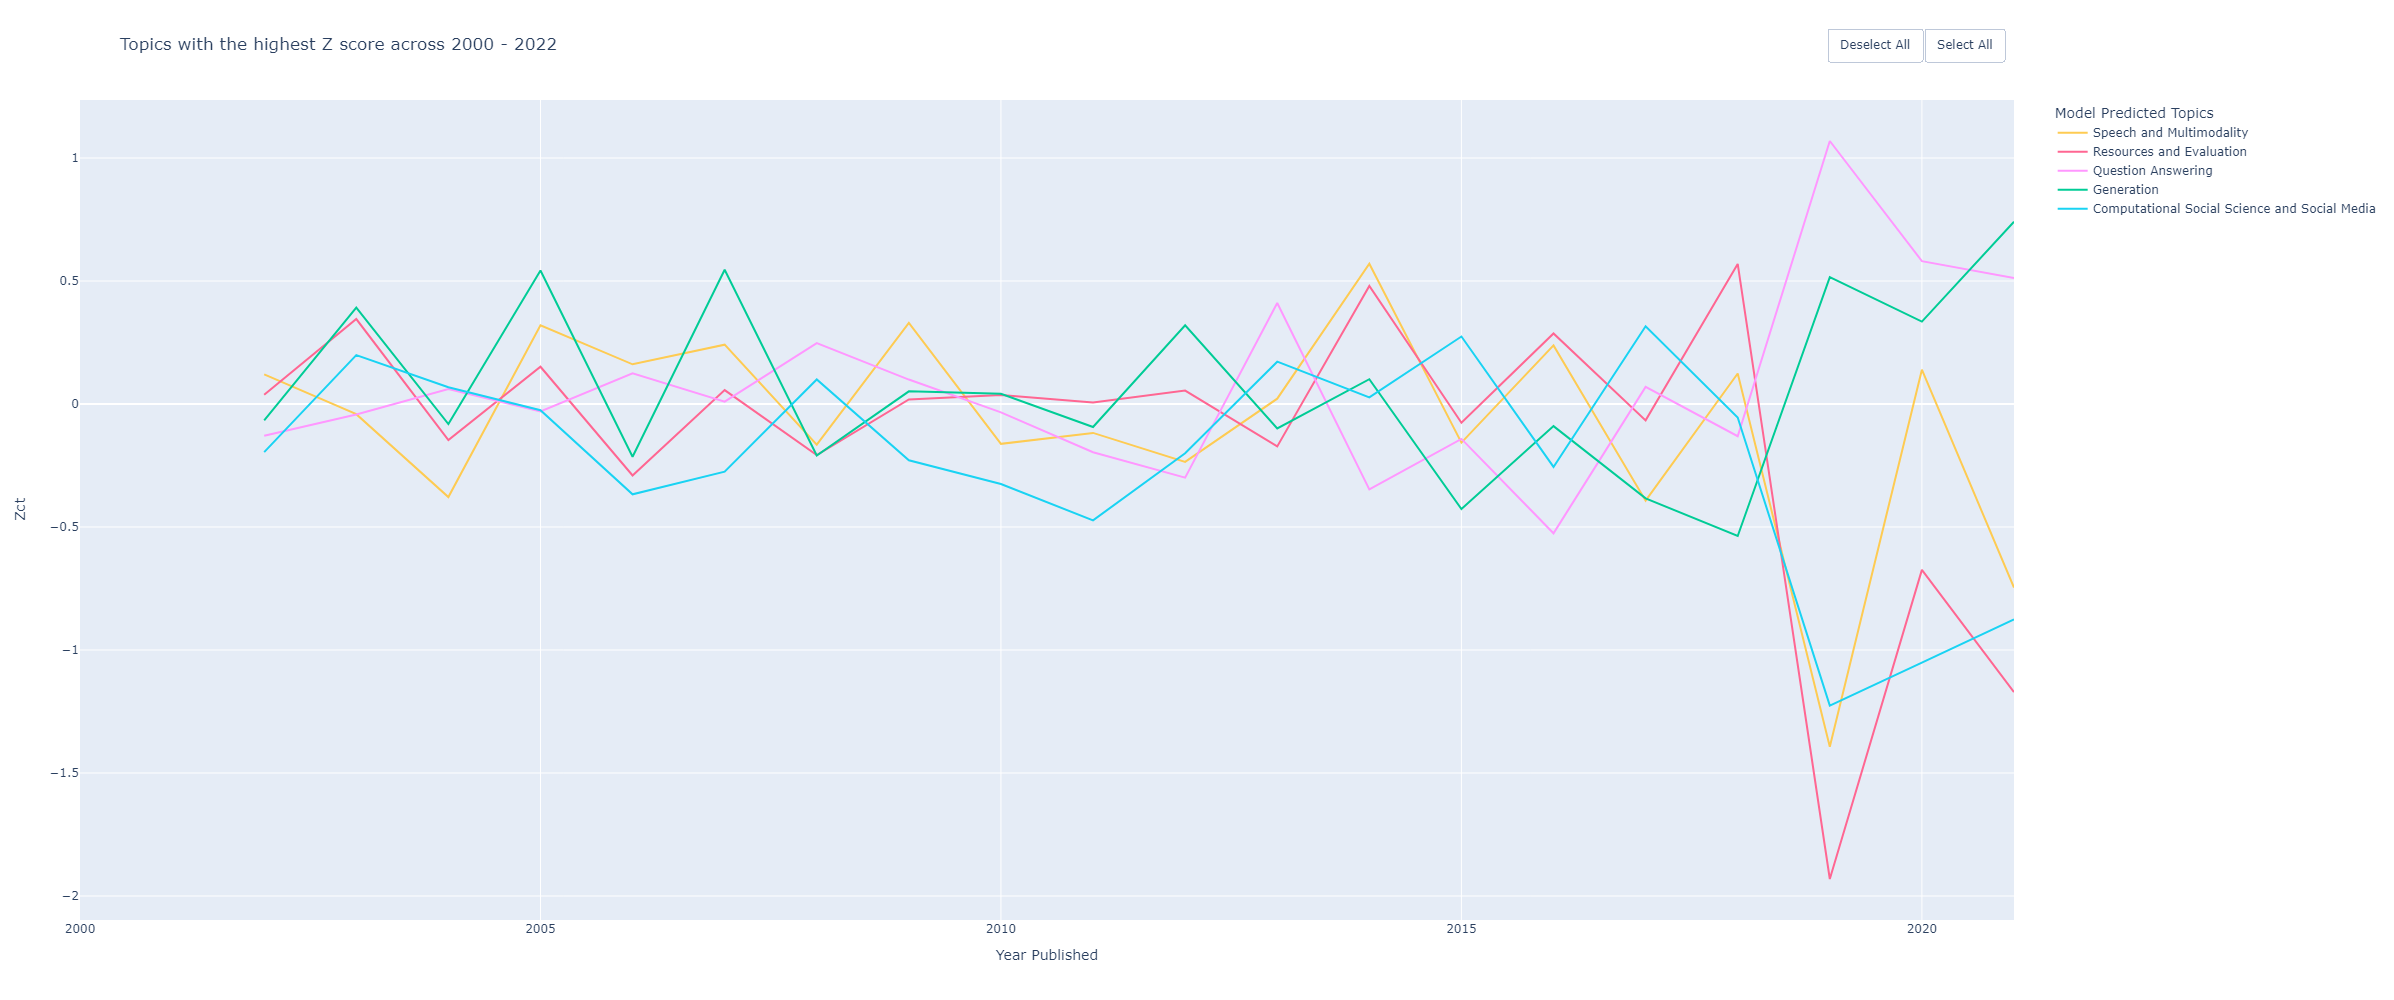

In [157]:
fig = px.scatter(pldf_plot_3, x="Year Published", y="Zct", color="Model Predicted Topics", color_discrete_map = color_discrete_map, title="Topics with the highest Z score across 2000 - 2022",
                 trendline="rolling", 
                 trendline_options=dict(window=3, win_type="gaussian", function_args=dict(std=2)),
                 width=2300,
                 height=1000)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))
fig.data = [t for t in fig.data if t.mode == "lines"]
fig.update_traces(showlegend=True)
fig.show()

### Count papers using windows that view numbers strictly before

In [158]:
def generating_Zct_back_only(emerge_df, k, start_date, end_date):
    
    f_c_t = emerge_df.groupby(['Year Published', 'Model Predicted Topics']).size().unstack(fill_value=0).stack()
    f_c_t = f_c_t.reset_index(name='Topic Count')
    f_c_t = f_c_t.sort_values(['Model Predicted Topics', 'Year Published'])
    
    f_c_t['Year Published'] = f_c_t['Year Published'].astype(int)
    
    # Counting the number of papers published per year
    N_t = f_c_t.groupby('Year Published')['Topic Count'].sum()
    N_t = N_t.reset_index(name='Paper Count')
    
    pc = f_c_t.groupby('Model Predicted Topics')['Topic Count'].rolling(k+1, min_periods = 1).sum().reset_index(name='Sliding sum of topic count')
    year_idx_mapping = f_c_t['Year Published'].reset_index(name='Year Published')
    
    pc = pc.merge(year_idx_mapping, left_on = 'level_1', right_on = 'index', how = 'inner').drop(['level_1', 'index'], axis = 1)
    pc = pc[["Year Published", "Model Predicted Topics", "Sliding sum of topic count"]]
    
    N_t['Sliding sum of total paper count'] = N_t['Paper Count'].rolling(k+1, min_periods = 1).sum()
    
    pc = pc.merge(N_t, on = 'Year Published', how = 'left')
    pc['Pc'] = pc['Sliding sum of topic count'] / pc['Sliding sum of total paper count']
    
    #This gives me N_t [Paper Count](total number of papers published per year), f_c_t [Topic Count](paper of a particular topic published per year) and p_c [Pc](expected probability count for topic per year)
    f_c_t = f_c_t.merge(pc, on = ['Year Published', 'Model Predicted Topics'], how = 'left')
    
    z_c_t = f_c_t.copy()
    z_c_t["Expected value"] = z_c_t['Paper Count'] * z_c_t['Pc']
    z_c_t["SD value"] = (z_c_t['Paper Count'] * z_c_t['Pc'] * (1 - z_c_t['Pc']))**(1/2)
    
    z_c_t['Zct'] = (z_c_t['Topic Count'] - z_c_t['Expected value'])/z_c_t['SD value']
    
    z_c_t['Zct'] = z_c_t['Zct'].fillna(0)
    z_c_t = z_c_t.sort_values(by="Year Published")
    z_c_t = z_c_t[(z_c_t['Year Published'] >= start_date) & (z_c_t['Year Published'] <= end_date)]
    
    return z_c_t

In [159]:
z_c_t = generating_Zct_back_only(emerge_df, 8, 2000, 2021) # Rolling window of t-k to t

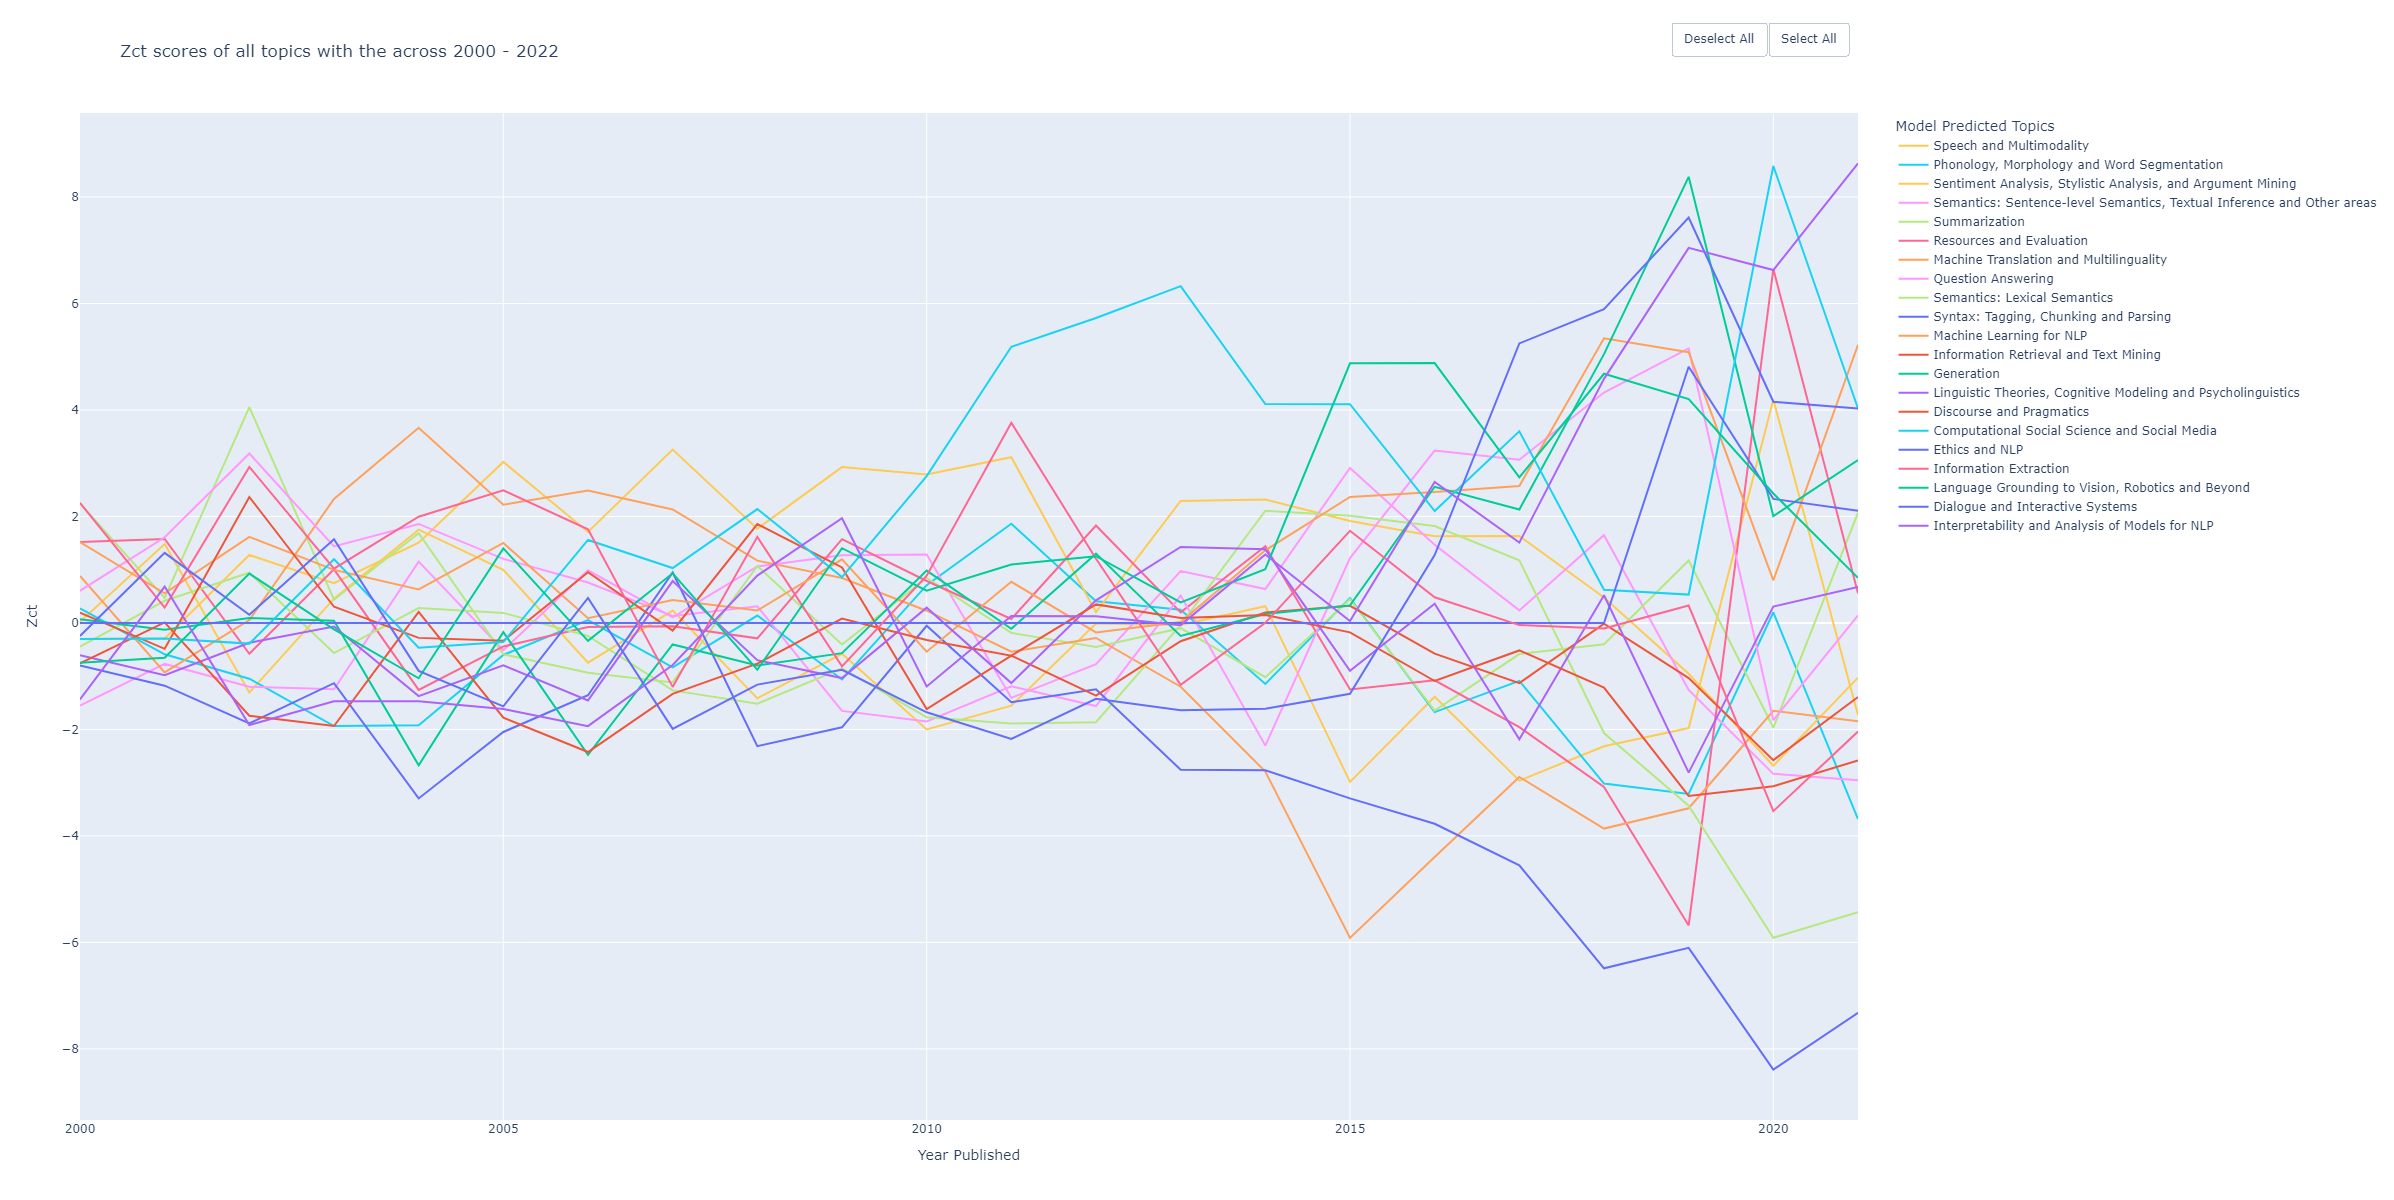

In [160]:
fig = px.line(z_c_t, x="Year Published", y="Zct", color="Model Predicted Topics", color_discrete_map = color_discrete_map, title="Zct scores of all topics with the across 2000 - 2022",
             width=1800, height=1200)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))

fig.show()

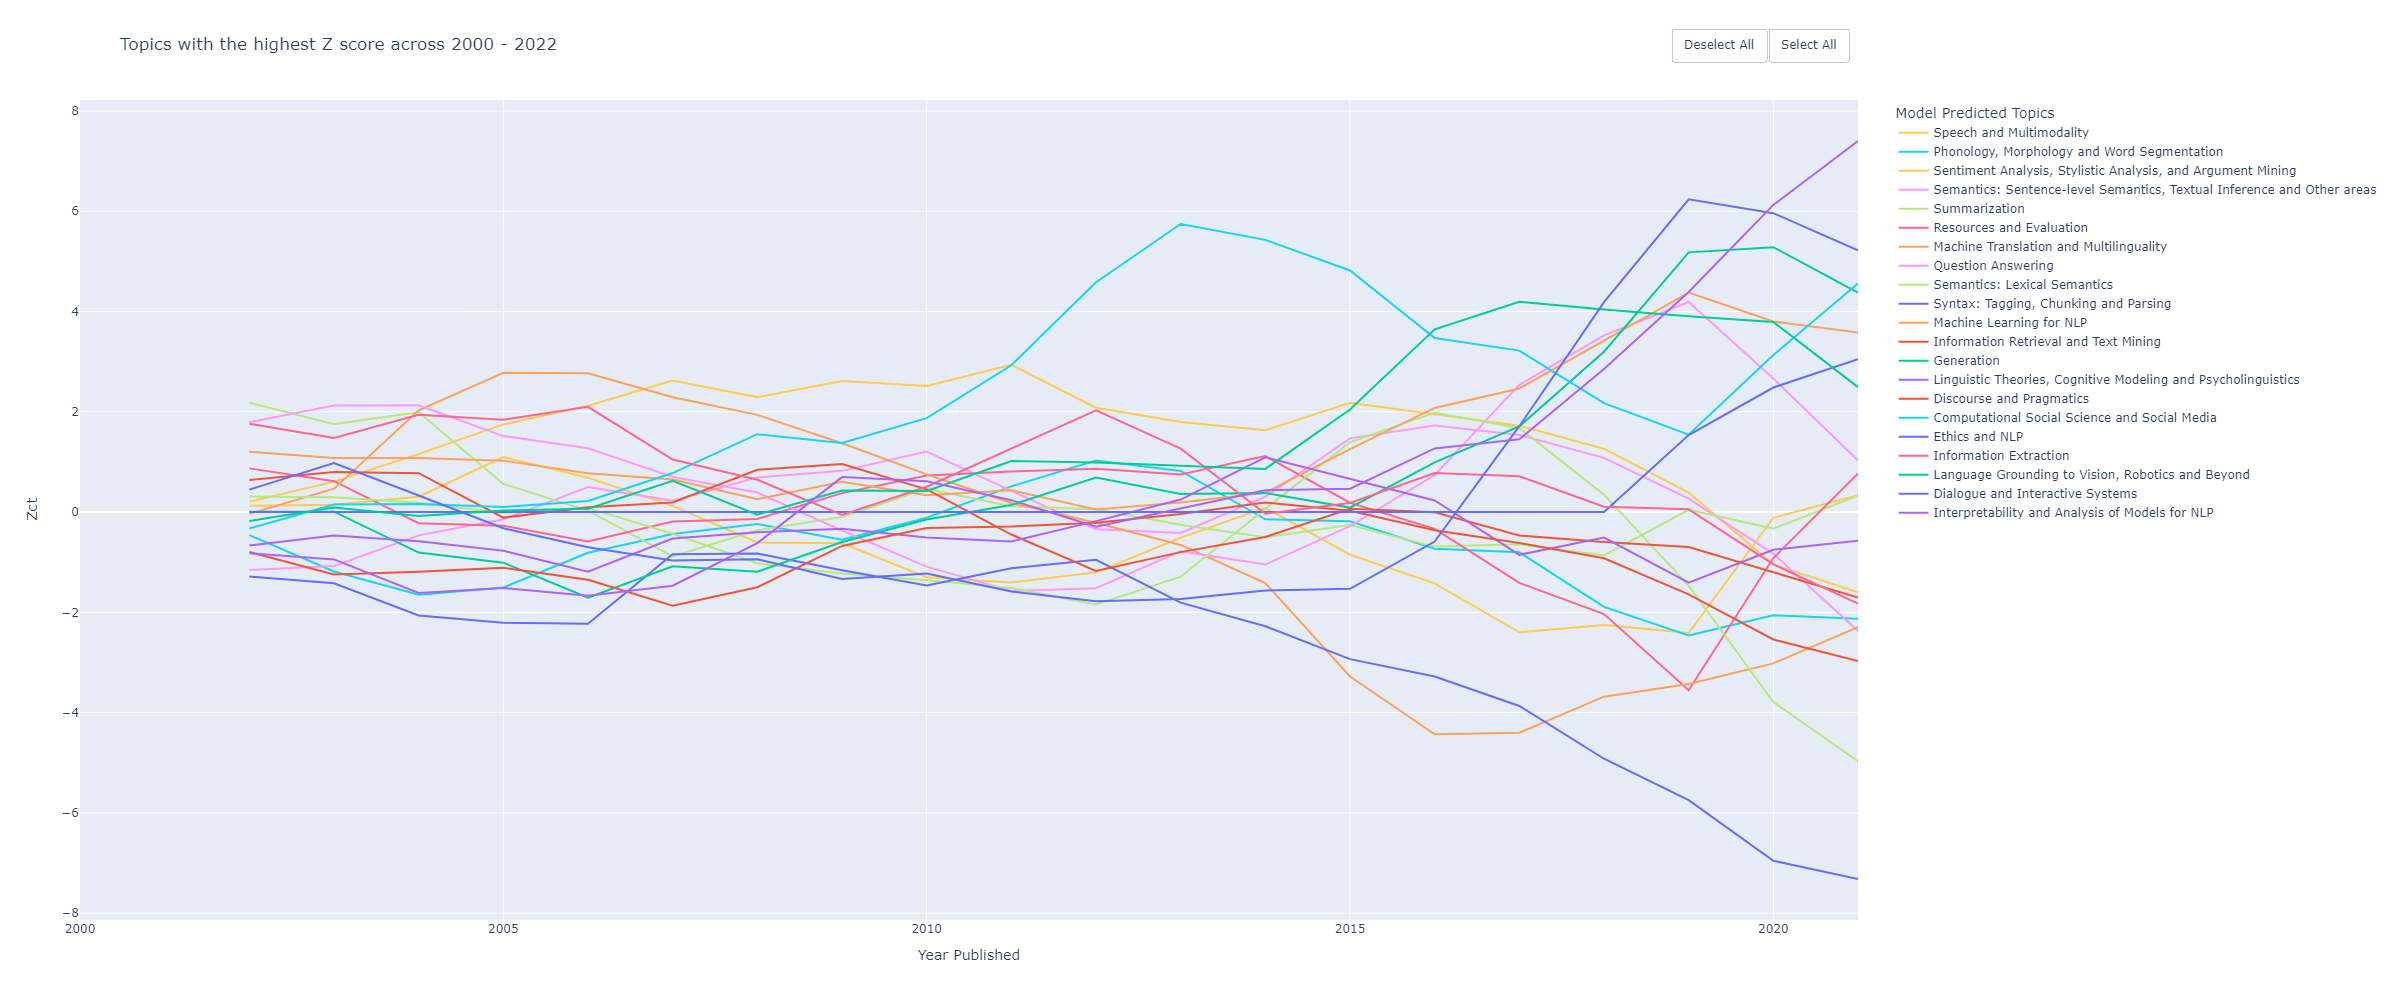

In [161]:
import plotly.express as px

fig = px.scatter(z_c_t, x="Year Published", y="Zct", color="Model Predicted Topics", color_discrete_map = color_discrete_map, title="Topics with the highest Z score across 2000 - 2022",
                 trendline="rolling", 
                 trendline_options=dict(window=3, win_type="gaussian", function_args=dict(std=2)),
                 width=2300,
                 height=1000)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))
fig.data = [t for t in fig.data if t.mode == "lines"]
fig.update_traces(showlegend=True)
fig.show()

### Plot top 5 topics with the widest z score with trendlines (gaussian rolling mean)

In [162]:
Topics_of_interest = list(z_c_t.groupby('Model Predicted Topics')['Zct'].agg(np.ptp).reset_index(name = "Diff z score").nlargest(5, "Diff z score")['Model Predicted Topics'])

In [163]:
pldf_plot_3 = z_c_t[z_c_t['Model Predicted Topics'].isin(Topics_of_interest)]

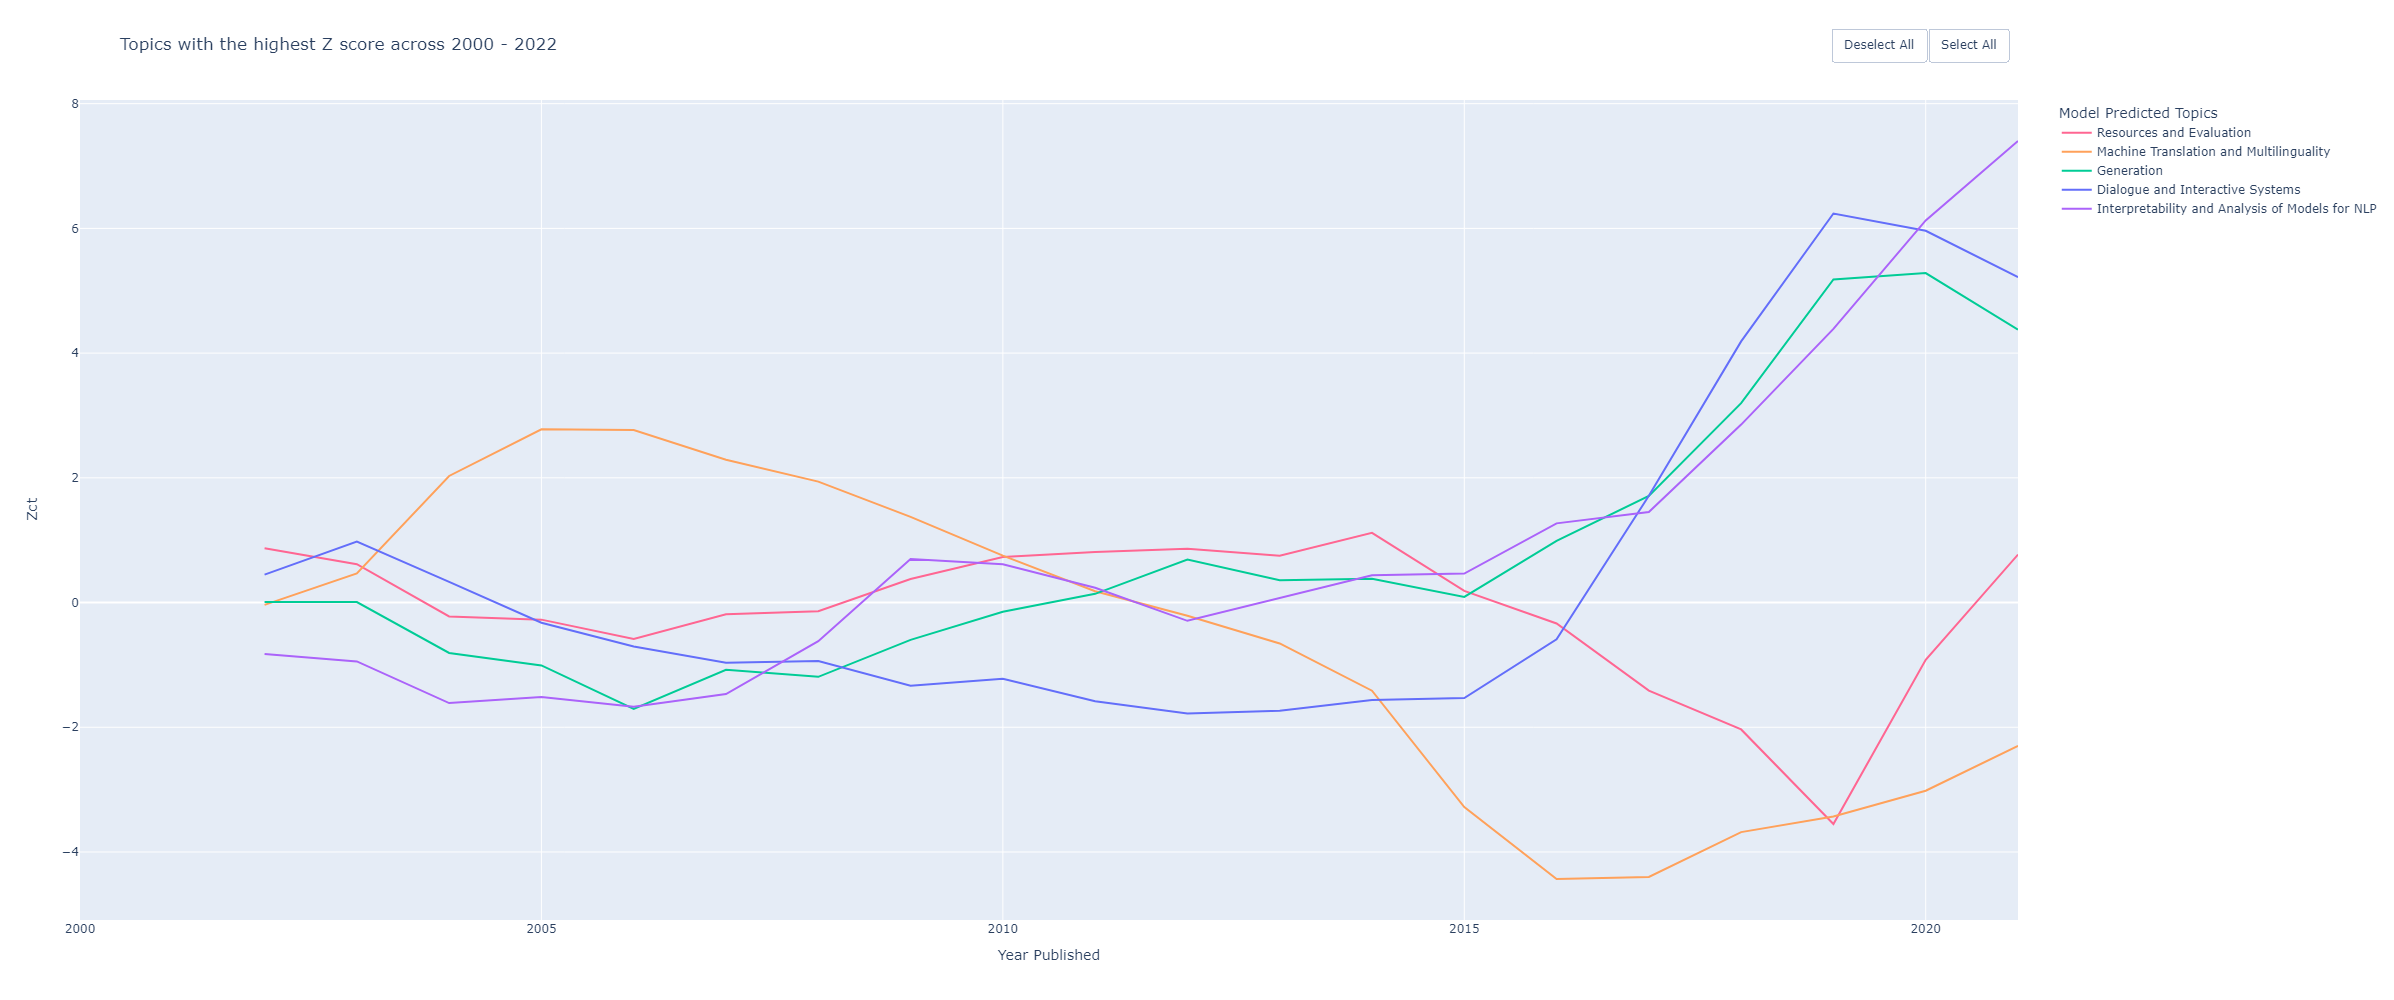

In [164]:
fig = px.scatter(pldf_plot_3, x="Year Published", y="Zct", color="Model Predicted Topics", color_discrete_map = color_discrete_map, title="Topics with the highest Z score across 2000 - 2022",
                 trendline="rolling", 
                 trendline_options=dict(window=3, win_type="gaussian", function_args=dict(std=2)),
                 width=2300,
                 height=1000)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))
fig.data = [t for t in fig.data if t.mode == "lines"]
fig.update_traces(showlegend=True)
fig.show()